<a href="https://colab.research.google.com/github/rajuzumaki2207/Bangalore_house_prediction/blob/main/RUL_TurboFan/4_TurboFan_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns



from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import os
 


plt.rcParams["figure.figsize"] = (20,10)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

## Import Data

In [8]:
## Train data and Test data
# define column names for easy indexing
index_names = ['id', 'cycles']
setting_names = ['op1', 'op2', 'op3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names
train = pd.read_csv("/content/drive/MyDrive/ML/Projects/RUL_TurboFan/train_FD001.txt", sep = "\s+", names=col_names)
test = pd.read_csv("/content/drive/MyDrive/ML/Projects/RUL_TurboFan/test_FD001.txt", sep = "\s+", names =col_names)
y_test = pd.read_csv('/content/drive/MyDrive/ML/Projects/RUL_TurboFan/RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

In [9]:
test_df= test.groupby('id').agg({'cycles':'max'})

In [10]:
test_df

,cycles
id,
1,31
2,49
3,126
4,106
5,98
...,...
96,97
97,134
98,121


In [11]:
y_test['cycles']=test_df['cycles'].values

In [12]:
y_test

,RUL,cycles
0,112,31
1,98,49
2,69,126
3,82,106
4,91,98
...,...,...
95,137,97
96,82,134
97,59,121
98,117,97


In [13]:
y_test["max"] = y_test["RUL"] + y_test["cycles"] 

In [14]:
y_test

,RUL,cycles,max
0,112,31,143
1,98,49,147
2,69,126,195
3,82,106,188
4,91,98,189
...,...,...,...
95,137,97,234
96,82,134,216
97,59,121,180
98,117,97,214


In [15]:
test_df['cycles']= y_test["RUL"].values + y_test["cycles"].values

In [16]:
test_df

,cycles
id,
1,143
2,147
3,195
4,188
5,189
...,...
96,234
97,216
98,180


In [17]:
train_df = train.groupby('id').agg({'cycles':'max'})

## Add RUL with add_rul function

In [18]:
def add_rul(df, max_df):
   # Get the total number of cycles for each unit
    max_cycle= max_df['cycles']
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='id', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

In [19]:
## Add RUL
train = add_rul(train, train_df)

## Deep Learning for Predictive Maintaince

Among the deep learning methods, Long Short Term Memory (LSTM) networks are especially appealing to the predictive maintenance domain due to the fact that they are very good at learning from sequences. This fact lends itself to their applications using time series data by making it possible to look back for longer periods of time to detect failure patterns. In this notebook, we build an LSTM network for the data set and scenerio described at [Predictive Maintenance Template](https://gallery.azure.ai/Collection/Predictive-Maintenance-Template-3) to predict remaining useful life of aircraft engines. In summary, the template uses simulated aircraft sensor values to predict when an aircraft engine will fail in the future so that maintenance can be planned in advance. 


This notebook uses keras deep learning library with Microsoft Cognitive Toolkit CNTK as backend.

In [20]:
w1= 30
w0 =15

train["label1"] = np.where(train["RUL"]<=w1,1,0)
train["label2"] = train["label1"]


In [21]:
train[(train["RUL"]<15) & (train["id"]==1)]

,id,cycles,op1,op2,op3,s_1,s_2,s_3,s_4,s_5,...,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,label1,label2
177,1,178,-0.0001,0.0002,100.0,518.67,643.38,1605.33,1424.65,14.62,...,8.4770,0.03,395,2388,100.0,38.65,23.1770,14,1,1
178,1,179,0.0023,-0.0003,100.0,518.67,642.86,1592.56,1429.45,14.62,...,8.4947,0.03,395,2388,100.0,38.77,23.1888,13,1,1
179,1,180,-0.0024,0.0000,100.0,518.67,643.58,1599.87,1417.14,14.62,...,8.4737,0.03,395,2388,100.0,38.86,23.0070,12,1,1
180,1,181,-0.0006,0.0005,100.0,518.67,643.44,1596.71,1420.64,14.62,...,8.4720,0.03,397,2388,100.0,38.34,23.1652,11,1,1
181,1,182,-0.0010,0.0003,100.0,518.67,644.21,1602.08,1426.62,14.62,...,8.5158,0.03,397,2388,100.0,38.43,23.1787,10,1,1
182,1,183,0.0001,0.0001,100.0,518.67,643.24,1597.23,1419.03,14.62,...,8.5041,0.03,396,2388,100.0,38.56,23.1302,9,1,1
183,1,184,0.0004,0.0003,100.0,518.67,644.07,1605.44,1432.52,14.62,...,8.5133,0.03,395,2388,100.0,38.43,23.0146,8,1,1
184,1,185,0.0008,0.0001,100.0,518.67,643.80,1603.46,1424.40,14.62,...,8.4984,0.03,395,2388,100.0,38.51,23.0700,7,1,1
185,1,186,0.0027,-0.0003,100.0,518.67,643.51,1595.16,1426.30,14.62,...,8.5227,0.03,397,2388,100.0,38.47,23.0564,6,1,1
186,1,187,-0.0047,-0.0000,100.0,518.67,643.32,1592.10,1427.27,14.62,...,8.5218,0.03,396,2388,100.0,38.42,23.0822,5,1,1


In [22]:
train.loc[train["RUL"]<=w0, "label2"]=2

In [23]:
train[(train["RUL"]<15) & (train["id"]==1)]

,id,cycles,op1,op2,op3,s_1,s_2,s_3,s_4,s_5,...,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,label1,label2
177,1,178,-0.0001,0.0002,100.0,518.67,643.38,1605.33,1424.65,14.62,...,8.4770,0.03,395,2388,100.0,38.65,23.1770,14,1,2
178,1,179,0.0023,-0.0003,100.0,518.67,642.86,1592.56,1429.45,14.62,...,8.4947,0.03,395,2388,100.0,38.77,23.1888,13,1,2
179,1,180,-0.0024,0.0000,100.0,518.67,643.58,1599.87,1417.14,14.62,...,8.4737,0.03,395,2388,100.0,38.86,23.0070,12,1,2
180,1,181,-0.0006,0.0005,100.0,518.67,643.44,1596.71,1420.64,14.62,...,8.4720,0.03,397,2388,100.0,38.34,23.1652,11,1,2
181,1,182,-0.0010,0.0003,100.0,518.67,644.21,1602.08,1426.62,14.62,...,8.5158,0.03,397,2388,100.0,38.43,23.1787,10,1,2
182,1,183,0.0001,0.0001,100.0,518.67,643.24,1597.23,1419.03,14.62,...,8.5041,0.03,396,2388,100.0,38.56,23.1302,9,1,2
183,1,184,0.0004,0.0003,100.0,518.67,644.07,1605.44,1432.52,14.62,...,8.5133,0.03,395,2388,100.0,38.43,23.0146,8,1,2
184,1,185,0.0008,0.0001,100.0,518.67,643.80,1603.46,1424.40,14.62,...,8.4984,0.03,395,2388,100.0,38.51,23.0700,7,1,2
185,1,186,0.0027,-0.0003,100.0,518.67,643.51,1595.16,1426.30,14.62,...,8.5227,0.03,397,2388,100.0,38.47,23.0564,6,1,2
186,1,187,-0.0047,-0.0000,100.0,518.67,643.32,1592.10,1427.27,14.62,...,8.5218,0.03,396,2388,100.0,38.42,23.0822,5,1,2


## Normalize the columns

In [24]:
# MinMax normalization
from sklearn.preprocessing import MinMaxScaler

train["cycle_norm"]= train["cycles"]

cols_normalize = train.columns.difference(["id", "cycles", "RUL", "label1", "label2"])


min_max_scaler = MinMaxScaler()

norm_train = pd.DataFrame(min_max_scaler.fit_transform(train[cols_normalize]),
                          columns= cols_normalize,
                          index= train.index
                          )

In [25]:
norm_train

,cycle_norm,op1,op2,op3,s_1,s_10,s_11,s_12,s_13,s_14,...,s_2,s_20,s_21,s_3,s_4,s_5,s_6,s_7,s_8,s_9
0,0.000000,0.459770,0.166667,0.0,0.0,0.0,0.369048,0.633262,0.205882,0.199608,...,0.183735,0.713178,0.724662,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755
1,0.002770,0.609195,0.250000,0.0,0.0,0.0,0.380952,0.765458,0.279412,0.162813,...,0.283133,0.666667,0.731014,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242
2,0.005540,0.252874,0.750000,0.0,0.0,0.0,0.250000,0.795309,0.220588,0.171793,...,0.343373,0.627907,0.621375,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043
3,0.008310,0.540230,0.500000,0.0,0.0,0.0,0.166667,0.889126,0.294118,0.174889,...,0.343373,0.573643,0.662386,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518
4,0.011080,0.390805,0.333333,0.0,0.0,0.0,0.255952,0.746269,0.235294,0.174734,...,0.349398,0.589147,0.704502,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,0.540166,0.477011,0.250000,0.0,0.0,0.0,0.726190,0.170576,0.558824,0.194344,...,0.686747,0.271318,0.109500,0.587312,0.782917,0.0,1.0,0.254428,0.439394,0.196491
20627,0.542936,0.408046,0.083333,0.0,0.0,0.0,0.708333,0.211087,0.500000,0.188668,...,0.701807,0.124031,0.366197,0.729453,0.866475,0.0,1.0,0.162641,0.500000,0.194651
20628,0.545706,0.522989,0.500000,0.0,0.0,0.0,0.738095,0.281450,0.529412,0.212148,...,0.665663,0.232558,0.053991,0.684979,0.775321,0.0,1.0,0.175523,0.515152,0.198196
20629,0.548476,0.436782,0.750000,0.0,0.0,0.0,0.916667,0.208955,0.514706,0.203065,...,0.608434,0.116279,0.234466,0.746021,0.747468,0.0,1.0,0.133655,0.530303,0.233285


In [26]:
join_df = train[train.columns.difference(cols_normalize)].join(norm_train)

In [27]:
train_df = join_df.reindex(columns= train.columns)
train_df.head()

,id,cycles,op1,op2,op3,s_1,s_2,s_3,s_4,s_5,...,s_16,s_17,s_18,s_19,s_20,s_21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [28]:
## test
test["cycle_norm"]= test["cycles"]

norm_test = pd.DataFrame(min_max_scaler.fit_transform(test[cols_normalize]),
                          columns= cols_normalize,
                          index= test.index
                          )
join_df = test[test.columns.difference(cols_normalize)].join(norm_test)
test_df = join_df.reindex(columns= test.columns)
test_df.head()

,id,cycles,op1,op2,op3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,cycle_norm
0,1,1,0.65625,0.692308,0.0,0.0,0.596215,0.421968,0.282214,0.0,...,0.325581,0.152259,0.347076,0.0,0.375,0.0,0.0,0.500000,0.620099,0.000000
1,1,2,0.34375,0.230769,0.0,0.0,0.182965,0.504025,0.225240,0.0,...,0.395349,0.277907,0.227709,0.0,0.500,0.0,0.0,0.645455,0.645718,0.003311
2,1,3,0.53125,0.538462,0.0,0.0,0.419558,0.464814,0.346130,0.0,...,0.325581,0.192892,0.533557,0.0,0.500,0.0,0.0,0.700000,0.681104,0.006623
3,1,4,0.77500,0.461538,0.0,0.0,0.413249,0.391587,0.449867,0.0,...,0.372093,0.217896,0.282359,0.0,0.250,0.0,0.0,0.627273,0.620382,0.009934
4,1,5,0.60000,0.461538,0.0,0.0,0.435331,0.471306,0.357974,0.0,...,0.325581,0.187891,0.337009,0.0,0.125,0.0,0.0,0.618182,0.676008,0.013245


In [29]:
test_df

,id,cycles,op1,op2,op3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,cycle_norm
0,1,1,0.65625,0.692308,0.0,0.0,0.596215,0.421968,0.282214,0.0,...,0.325581,0.152259,0.347076,0.0,0.375,0.0,0.0,0.500000,0.620099,0.000000
1,1,2,0.34375,0.230769,0.0,0.0,0.182965,0.504025,0.225240,0.0,...,0.395349,0.277907,0.227709,0.0,0.500,0.0,0.0,0.645455,0.645718,0.003311
2,1,3,0.53125,0.538462,0.0,0.0,0.419558,0.464814,0.346130,0.0,...,0.325581,0.192892,0.533557,0.0,0.500,0.0,0.0,0.700000,0.681104,0.006623
3,1,4,0.77500,0.461538,0.0,0.0,0.413249,0.391587,0.449867,0.0,...,0.372093,0.217896,0.282359,0.0,0.250,0.0,0.0,0.627273,0.620382,0.009934
4,1,5,0.60000,0.461538,0.0,0.0,0.435331,0.471306,0.357974,0.0,...,0.325581,0.187891,0.337009,0.0,0.125,0.0,0.0,0.618182,0.676008,0.013245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.81875,0.461538,0.0,0.0,0.665615,0.789665,0.641209,0.0,...,0.255814,0.935703,0.664909,0.0,0.625,0.0,0.0,0.309091,0.370842,0.639073
13092,100,195,0.44375,0.384615,0.0,0.0,0.659306,0.692028,0.769042,0.0,...,0.465116,0.914003,0.567593,0.0,0.750,0.0,0.0,0.236364,0.483652,0.642384
13093,100,196,0.47500,0.230769,0.0,0.0,0.728707,0.626071,0.458036,0.0,...,0.348837,0.971066,0.594919,0.0,0.750,0.0,0.0,0.281818,0.381741,0.645695
13094,100,197,0.27500,0.538462,0.0,0.0,0.671924,0.673851,0.714111,0.0,...,0.441860,1.000000,0.662991,0.0,0.750,0.0,0.0,0.318182,0.473461,0.649007


In [30]:
y_test

,RUL,cycles,max
0,112,31,143
1,98,49,147
2,69,126,195
3,82,106,188
4,91,98,189
...,...,...,...
95,137,97,234
96,82,134,216
97,59,121,180
98,117,97,214


In [31]:
y_test["id"]= y_test.index+1
g_truth = y_test.drop(["cycles", "RUL"], axis=1)


In [32]:
g_truth.columns = ["max", "id"]
g_truth

,max,id
0,143,1
1,147,2
2,195,3
3,188,4
4,189,5
...,...,...
95,234,96
96,216,97
97,180,98
98,214,99


In [33]:
test_df = test_df.merge(g_truth, on=["id"], how="left")
test_df.head()

,id,cycles,op1,op2,op3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,cycle_norm,max
0,1,1,0.65625,0.692308,0.0,0.0,0.596215,0.421968,0.282214,0.0,...,0.152259,0.347076,0.0,0.375,0.0,0.0,0.500000,0.620099,0.000000,143
1,1,2,0.34375,0.230769,0.0,0.0,0.182965,0.504025,0.225240,0.0,...,0.277907,0.227709,0.0,0.500,0.0,0.0,0.645455,0.645718,0.003311,143
2,1,3,0.53125,0.538462,0.0,0.0,0.419558,0.464814,0.346130,0.0,...,0.192892,0.533557,0.0,0.500,0.0,0.0,0.700000,0.681104,0.006623,143
3,1,4,0.77500,0.461538,0.0,0.0,0.413249,0.391587,0.449867,0.0,...,0.217896,0.282359,0.0,0.250,0.0,0.0,0.627273,0.620382,0.009934,143
4,1,5,0.60000,0.461538,0.0,0.0,0.435331,0.471306,0.357974,0.0,...,0.187891,0.337009,0.0,0.125,0.0,0.0,0.618182,0.676008,0.013245,143


In [34]:
test_df["RUL"] = test_df["max"]- test_df["cycles"]

In [35]:
test_df.drop("max", axis =1, inplace=True)
test_df.head()

,id,cycles,op1,op2,op3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,cycle_norm,RUL
0,1,1,0.65625,0.692308,0.0,0.0,0.596215,0.421968,0.282214,0.0,...,0.152259,0.347076,0.0,0.375,0.0,0.0,0.500000,0.620099,0.000000,142
1,1,2,0.34375,0.230769,0.0,0.0,0.182965,0.504025,0.225240,0.0,...,0.277907,0.227709,0.0,0.500,0.0,0.0,0.645455,0.645718,0.003311,141
2,1,3,0.53125,0.538462,0.0,0.0,0.419558,0.464814,0.346130,0.0,...,0.192892,0.533557,0.0,0.500,0.0,0.0,0.700000,0.681104,0.006623,140
3,1,4,0.77500,0.461538,0.0,0.0,0.413249,0.391587,0.449867,0.0,...,0.217896,0.282359,0.0,0.250,0.0,0.0,0.627273,0.620382,0.009934,139
4,1,5,0.60000,0.461538,0.0,0.0,0.435331,0.471306,0.357974,0.0,...,0.187891,0.337009,0.0,0.125,0.0,0.0,0.618182,0.676008,0.013245,138


In [36]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycles,op1,op2,op3,s_1,s_2,s_3,s_4,s_5,...,s_16,s_17,s_18,s_19,s_20,s_21,cycle_norm,RUL,label1,label2
0,1,1,0.65625,0.692308,0.0,0.0,0.596215,0.421968,0.282214,0.0,...,0.0,0.375,0.0,0.0,0.500000,0.620099,0.000000,142,0,0
1,1,2,0.34375,0.230769,0.0,0.0,0.182965,0.504025,0.225240,0.0,...,0.0,0.500,0.0,0.0,0.645455,0.645718,0.003311,141,0,0
2,1,3,0.53125,0.538462,0.0,0.0,0.419558,0.464814,0.346130,0.0,...,0.0,0.500,0.0,0.0,0.700000,0.681104,0.006623,140,0,0
3,1,4,0.77500,0.461538,0.0,0.0,0.413249,0.391587,0.449867,0.0,...,0.0,0.250,0.0,0.0,0.627273,0.620382,0.009934,139,0,0
4,1,5,0.60000,0.461538,0.0,0.0,0.435331,0.471306,0.357974,0.0,...,0.0,0.125,0.0,0.0,0.618182,0.676008,0.013245,138,0,0


## Modelling

Traditional predictive maintaince machine learning models are based on feature engineering which is manual construction of right features using domain expertise and similar methods. This usually makes these models hard to reuse since feature engineering is specific to the problem scenario and the available data which varies from one business to the other. Perhaps the most attractive part of applying deep learning in the predictive maintenance domain is the fact that these networks can automatically extract the right features from the data, eliminating the need for manual feature engineering.


For using LSTMs in time series domain,one important parameter to pick is the sequence length which is the window for LSTMs to look back. This may be viewed as similar to picking window_size = 5 cycles for calculating the rolling features in the Predictive Maintenance Template which are rolling mean and rolling standard deviation for 21 sensor values. The idea of using LSTMs is to let the model extract abstract features out of the sequence of sensor values in the window rather than engineering those manually. The expectation is that if there is a pattern in these sensor values within the window prior to failure, the pattern should be encoded by the LSTM.

In [37]:
## pick a large window size of 50 cycles

sequence_length = 50


In [38]:
## preparing data for visualizations
##
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]

In [39]:
def gen_sequence(id, seq_length, seq_cols):
  """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """

  data_array = id[seq_cols].values
  num_elements = data_array.shape[0]

  for start, stop in zip(range(0, num_elements-seq_length), range(seq_length,num_elements)):
    yield data_array[start:stop,:]

In [91]:
for start , stop  in list(zip( range(0, 129), range(50, 179))):
  print (start,stop)
  break

0 50


In [41]:
index_names = ['id', 'cycles']
setting_names = ['op1', 'op2', 'op3',"cycle_norm"]
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
seq_col= setting_names + sensor_names
xx=(train_df[train_df['id']==3],50, seq_col) ## test for engine ID 3

In [43]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, seq_col)) 
           for id in train_df['id'].unique())

In [44]:
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

In [45]:
seq_array.shape

(15631, 50, 25)

In [46]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [47]:
## generate labels

label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [48]:
num_of_features = seq_array.shape[2]

num_of_out = label_array.shape[1]



## Lets build an LSTM Network

In [ ]:
from tensorflow import keras

from tensorflow.keras.layers import Dropout, LSTM, Dense

model = keras.Sequential()
  
model.add(LSTM(
    input_shape = (sequence_length, num_of_features),
    units = 128,
    return_sequences =True
    ))
model.add(Dropout(0.2))
model.add(LSTM(
    units=64,
    return_sequences =False

))

model.add(Dropout(0.2))

model.add(Dense(units =num_of_out,activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Accuracy'])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 128)           78848     
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 128,321
Trainable params: 128,321
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
checkpoint_filepath = "/content/drive/MyDrive/ML/Projects/RUL_TurboFan/LSTM.ckpt"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
)

In [ ]:
from keras import callbacks


%time
# fit the network
history = model.fit(seq_array, label_array, epochs=50, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [model_checkpoint_callback, model_early_stopping])

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.82 µs
Epoch 1/50
75/75 [==============================] - 15s 90ms/step - loss: 0.2411 - Accuracy: 0.8984 - val_loss: 0.1499 - val_Accuracy: 0.9335
Epoch 2/50
75/75 [==============================] - 3s 43ms/step - loss: 0.0981 - Accuracy: 0.9616 - val_loss: 0.0416 - val_Accuracy: 0.9885
Epoch 3/50
75/75 [==============================] - 2s 30ms/step - loss: 0.0818 - Accuracy: 0.9658 - val_loss: 0.1024 - val_Accuracy: 0.9463
Epoch 4/50
75/75 [==============================] - 2s 29ms/step - loss: 0.0742 - Accuracy: 0.9683 - val_loss: 0.0451 - val_Accuracy: 0.9872
Epoch 5/50
75/75 [==============================] - 2s 29ms/step - loss: 0.0684 - Accuracy: 0.9710 - val_loss: 0.0619 - val_Accuracy: 0.9668
Epoch 6/50
75/75 [==============================] - 2s 29ms/step - loss: 0.0657 - Accuracy: 0.9719 - val_loss: 0.0437 - val_Accuracy: 0.9795
Epoch 7/50
75/75 [==============================] - 2s 30ms/step - loss: 0.0614 - Accurac

In [ ]:
## Model save
model.save('/content/drive/MyDrive/ML/Projects/RUL_TurboFan')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/Projects/RUL_TurboFan/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/Projects/RUL_TurboFan/assets


## Save history

In [ ]:
## save history
np.save('/content/drive/MyDrive/ML/Projects/RUL_TurboFan/my_history.npy',history.history)

In [ ]:
## load history
hist = np.load('/content/drive/MyDrive/ML/Projects/RUL_TurboFan/my_history.npy',allow_pickle='TRUE').item()

In [ ]:
history.history["Accuracy"] = hist["Accuracy"]

## Load saved Model

In [ ]:
## load model
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/ML/Projects/RUL_TurboFan')

In [ ]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 6s 15ms/step - loss: 0.0482 - Accuracy: 0.9790
Accurracy: 0.9790160655975342


In [ ]:
# make predictions and compute confusion matrix
from sklearn.metrics import confusion_matrix, recall_score, precision_score

y_pred = (model.predict(seq_array,verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 3s 16ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12256,   275],
       [  118,  2982]])

In [ ]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9155664722136936 
 recall =  0.9619354838709677


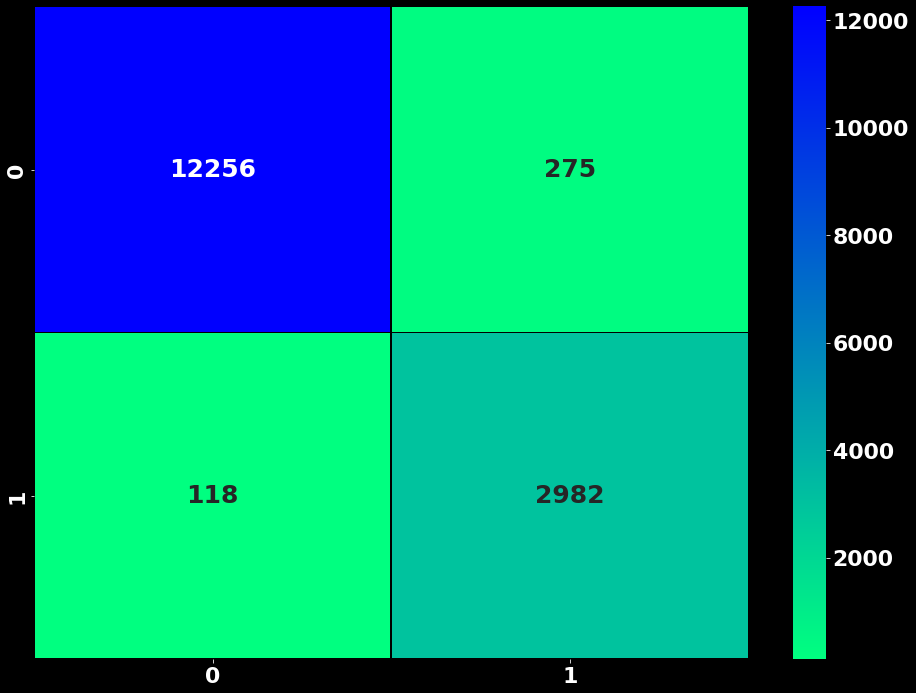

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16,12))
sns.heatmap(cm,annot=True,annot_kws={"size": 25},linewidths=0.7,linecolor="black",cmap="winter_r",fmt="d")

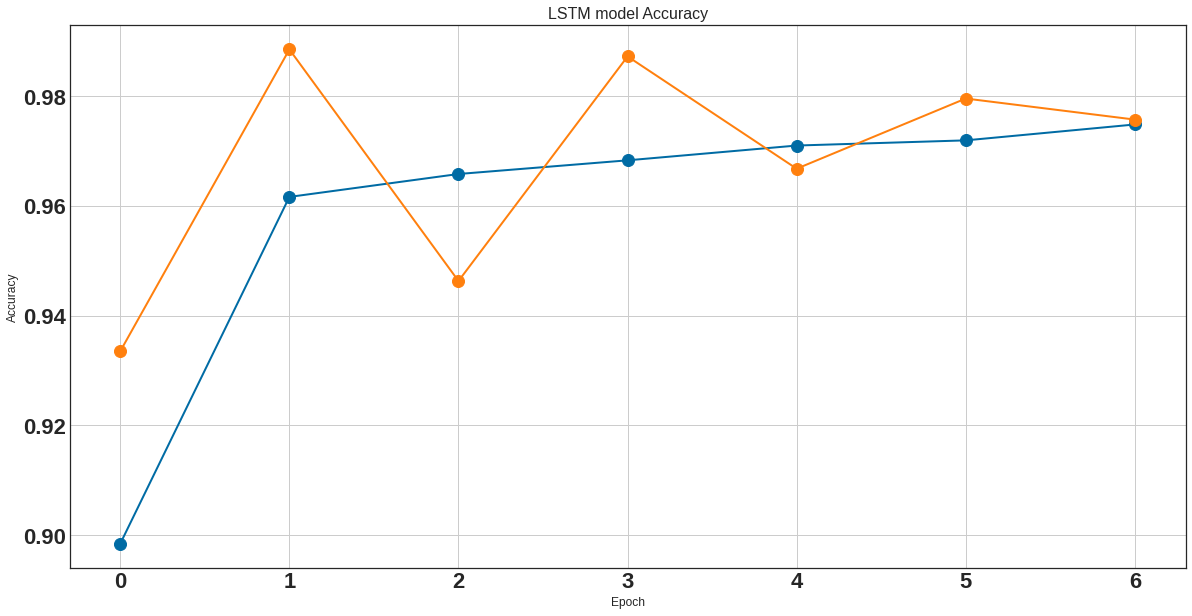

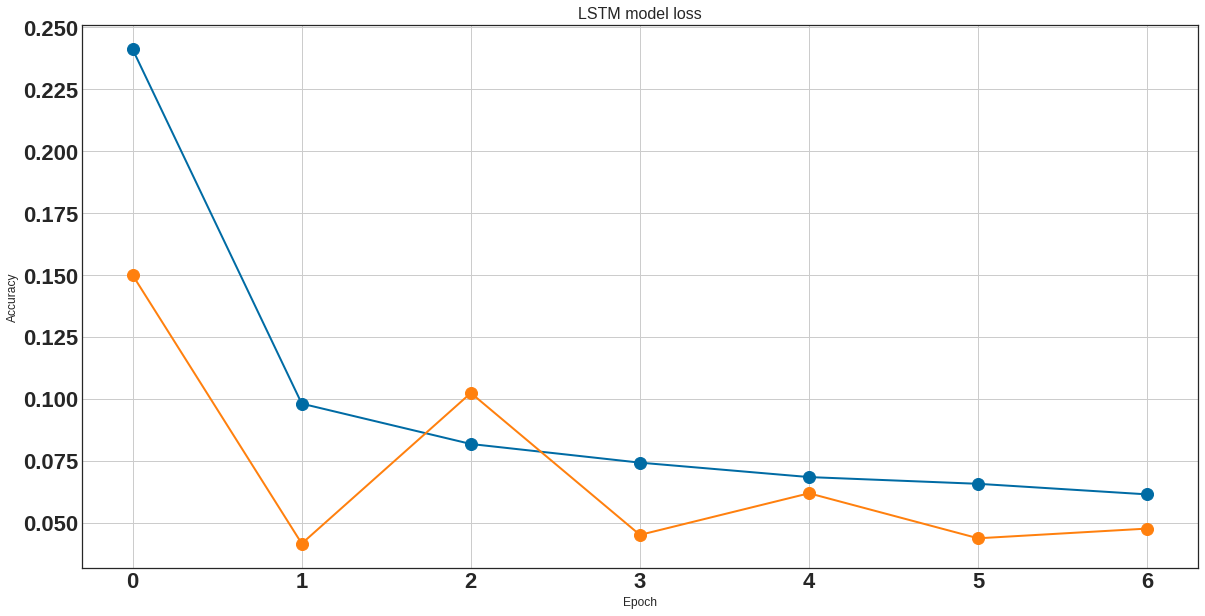

In [ ]:
# summarize history for accuracy
plt.style.use("seaborn-white")
fig, ax = plt.subplots()
ax.grid()
ax.plot(history.history["Accuracy"], linewidth=2, markersize=12, marker= "o")
ax.plot(history.history["val_Accuracy"],linewidth=2, markersize=12,marker= "o")
ax.set(title='LSTM model Accuracy',
    ylabel='Accuracy', xlabel='Epoch')

fig1, ax1 = plt.subplots()
ax1.grid()
ax1.plot(history.history["loss"], linewidth=2, markersize=12, marker= "o")
ax1.plot(history.history["val_loss"],linewidth=2, markersize=12,marker= "o")
ax1.set(title='LSTM model loss',
    ylabel='Accuracy', xlabel='Epoch')



plt.show()

In [ ]:
fig.savefig("/content/drive/MyDrive/ML/Projects/RUL_TurboFan/model_accuracy.png")
fig1.savefig("/content/drive/MyDrive/ML/Projects/RUL_TurboFan/model_loss.png")

## Evaluation on Validation set



In [ ]:

seq_array_test_last = [test_df[test_df['id']==id][seq_col].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

In [ ]:
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

In [ ]:
y_mask= [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [ ]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values

In [ ]:
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

In [ ]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.6649 - Accuracy: 0.8495 - 54ms/epoch - 18ms/step
Accurracy: 0.8494623899459839


In [ ]:

# make predictions and compute confusion matrix
y_pred_test = (model.predict(seq_array_test_last,verbose=1, batch_size=20) > 0.5).astype("int32")
y_true_test = label_array_test_last

5/5 [==============================] - 0s 10ms/step


In [ ]:
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm) ## Remember we trained the model for Recall

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[54 14]
 [ 0 25]]


In [ ]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.6410256410256411 
 Recall:  1.0 
 F1-score: 0.7812500000000001


 <font color=Red>We see the precision takes a hit when trained for Recall. Based on my experience, False postive should not be that alarming as False Negative as if the engine actually fails but our model is predicting it to not fail it could be catestophic

## RNN based Regression 
After classifying whether the engine will fail or not, another question is when will it fail?

In [49]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = '/content/drive/MyDrive/ML/Projects/RUL_TurboFan/regression_model.h5'

In [50]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

In [51]:

x=train_df[train_df['id']==1]["RUL"].values
x.shape[0]

192

In [93]:
x[0:50 :]

array([191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 179,
       178, 177, 176, 175, 174, 173, 172, 171, 170, 169, 168, 167, 166,
       165, 164, 163, 162, 161, 160, 159, 158, 157, 156, 155, 154, 153,
       152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142])

In [53]:
# labels as np
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [54]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [82]:
train_df[train_df.id==1].shape

(192, 30)

In [55]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

In [154]:
checkpoint_filepath_reg = "/content/drive/MyDrive/ML/Projects/RUL_TurboFan/reg"
model_checkpoint_callback_reg= keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_reg,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model_early_stopping_reg = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    
    patience=15,
    verbose=0,
    mode='min',
)

In [155]:
## LSTMS model

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=128,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=64,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

In [156]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 128)           78848     
                                                                 
 dropout_2 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 128,321
Trainable params: 128,321
Non-tr

In [157]:
# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [model_checkpoint_callback_reg,
                       model_early_stopping_reg]
          )


Epoch 1/100
75/75 - 7s - loss: 8565.9189 - mae: 73.7603 - r2_keras: -1.6420e+00 - val_loss: 7935.6587 - val_mae: 70.5778 - val_r2_keras: -2.3222e+00 - 7s/epoch - 95ms/step
Epoch 2/100
75/75 - 2s - loss: 7781.1021 - mae: 69.1920 - r2_keras: -1.3996e+00 - val_loss: 7292.6035 - val_mae: 66.8568 - val_r2_keras: -2.0201e+00 - 2s/epoch - 29ms/step
Epoch 3/100
75/75 - 2s - loss: 7160.7578 - mae: 65.6243 - r2_keras: -1.2040e+00 - val_loss: 6697.2559 - val_mae: 63.4398 - val_r2_keras: -1.7436e+00 - 2s/epoch - 29ms/step
Epoch 4/100
75/75 - 2s - loss: 6580.1602 - mae: 62.3528 - r2_keras: -1.0254e+00 - val_loss: 6149.2749 - val_mae: 60.3244 - val_r2_keras: -1.4924e+00 - 2s/epoch - 29ms/step
Epoch 5/100
75/75 - 2s - loss: 6049.9292 - mae: 59.4068 - r2_keras: -8.6662e-01 - val_loss: 5647.5806 - val_mae: 57.5045 - val_r2_keras: -1.2661e+00 - 2s/epoch - 29ms/step
Epoch 6/100
75/75 - 2s - loss: 5575.5791 - mae: 56.7602 - r2_keras: -7.1733e-01 - val_loss: 5193.7427 - val_mae: 54.9884 - val_r2_keras: -1.

In [159]:
## save history
np.save('/content/drive/MyDrive/ML/Projects/RUL_TurboFan/regmy_history.npy',history.history)

In [160]:
## regression
model.save('/content/drive/MyDrive/ML/Projects/RUL_TurboFan/reg')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/Projects/RUL_TurboFan/reg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/Projects/RUL_TurboFan/reg/assets


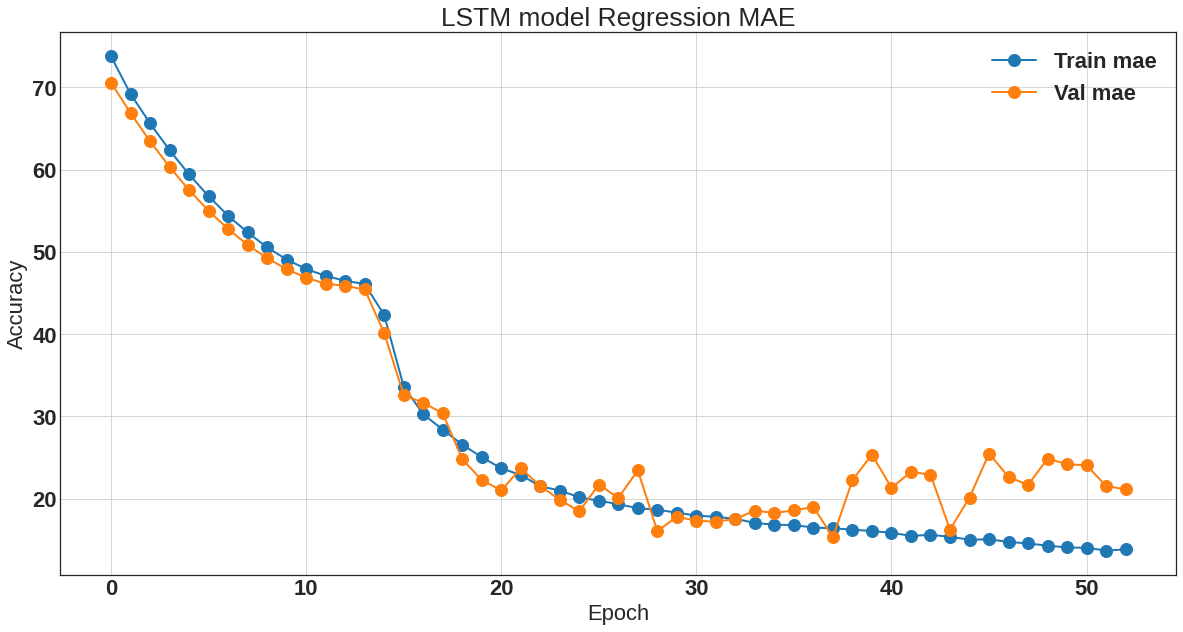

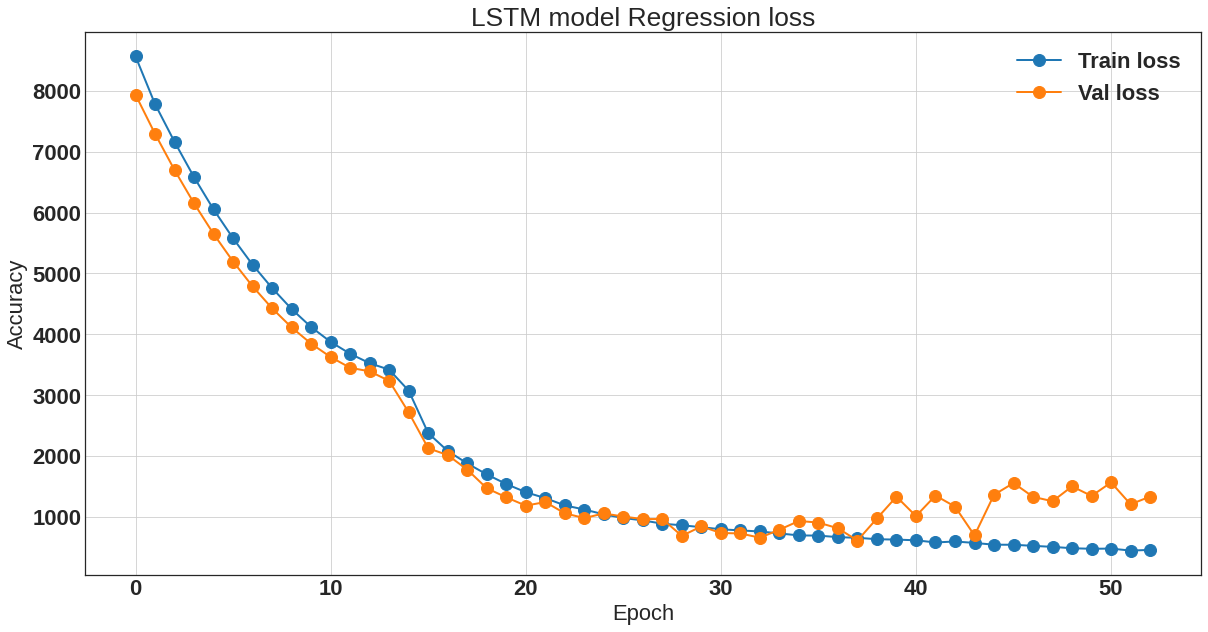

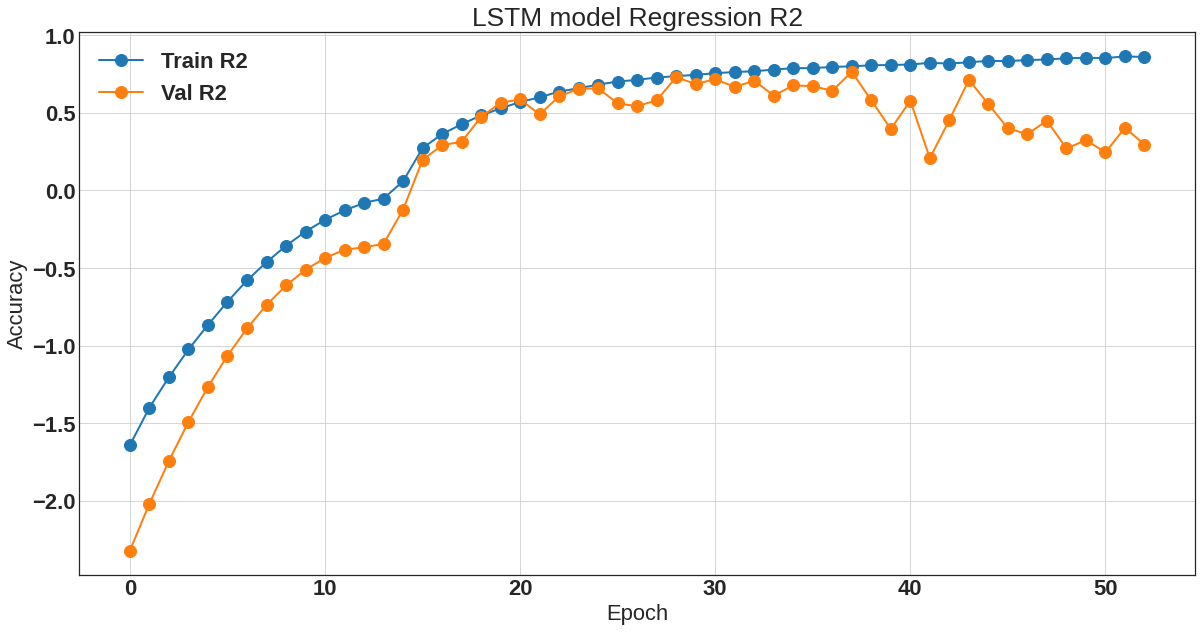

In [161]:
# summarize history for accuracy
plt.style.use("seaborn-white")
fig, ax = plt.subplots()
ax.grid()
ax.plot(history.history["mae"], linewidth=2, markersize=12, marker= "o",label = "Train mae" )
ax.plot(history.history["val_mae"],linewidth=2, markersize=12,marker= "o", label = "Val mae")
ax.set(title='LSTM model Regression MAE',
    ylabel='Accuracy', xlabel='Epoch')
ax.legend()

fig1, ax1 = plt.subplots()
ax1.grid()
ax1.plot(history.history["loss"], linewidth=2, markersize=12, marker= "o" , label = "Train loss")
ax1.plot(history.history["val_loss"],linewidth=2, markersize=12,marker= "o", label = "Val loss")
ax1.set(title='LSTM model Regression loss',
    ylabel='Accuracy', xlabel='Epoch' )
ax1.legend()

fig2, ax2= plt.subplots()
ax2.grid()
ax2.plot(history.history["r2_keras"], linewidth=2, markersize=12, marker= "o", label = "Train R2")
ax2.plot(history.history["val_r2_keras"],linewidth=2, markersize=12,marker= "o", label = "Val R2")
ax2.set(title='LSTM model Regression R2',
    ylabel='Accuracy', xlabel='Epoch' )
ax2.legend()

plt.show()

In [162]:
# Save the plots for future reference
fig.savefig("/content/drive/MyDrive/ML/Projects/RUL_TurboFan/reg_mae.png")
fig1.savefig("/content/drive/MyDrive/ML/Projects/RUL_TurboFan/reg_loss.png")
fig2.savefig("/content/drive/MyDrive/ML/Projects/RUL_TurboFan/reg_r2.png")

In [163]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

79/79 [==============================] - 1s 15ms/step - loss: 439.6584 - mae: 12.8828 - r2_keras: 0.8263

MAE: 12.882784843444824

R^2: 0.8262690305709839


## Make inference

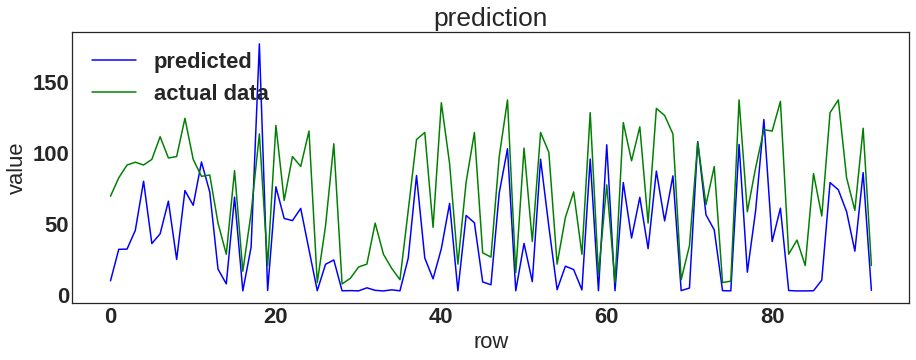

In [173]:
 # We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][seq_col].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it

estimator = load_model("/content/drive/MyDrive/ML/Projects/RUL_TurboFan/reg",custom_objects={'r2_keras': r2_keras})

# test metrics


y_pred_test = estimator.predict(seq_array_test_last)
y_true_test = label_array_test_last

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(15, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_regression_verify.png")